
# UNet based magnetic resonance (MR) image segmentation of the brain 

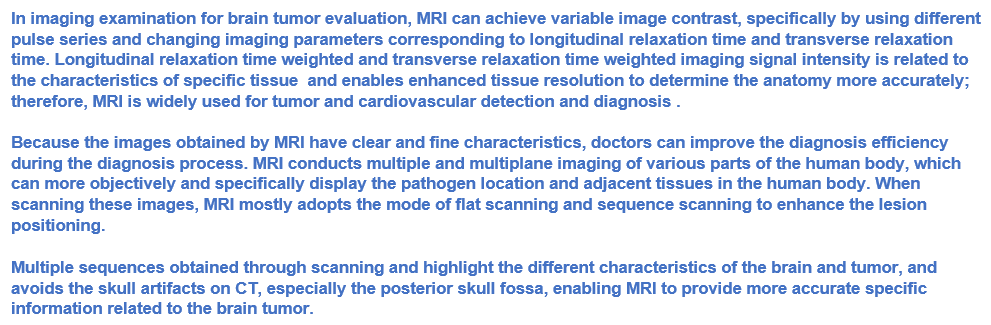

![ChessUrl](https://upload.wikimedia.org/wikipedia/commons/a/a4/High_Resolution_FMRI_of_the_Human_Brain.gif "chess")




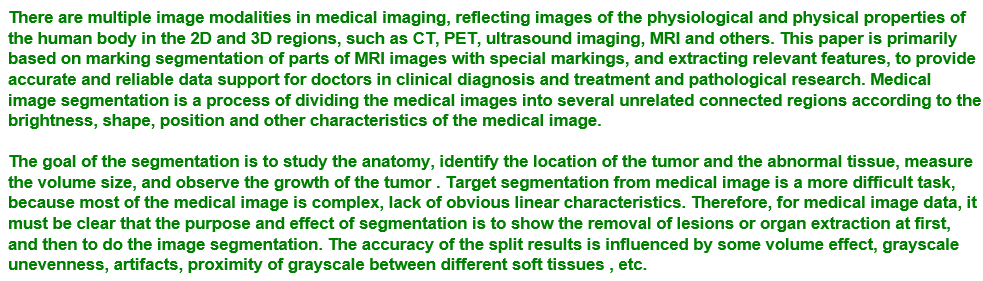
## Load and Explore the Dataset

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from matplotlib import image
from pathlib import Path
from tensorflow.keras import models, layers, Model, Input
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from matplotlib import image
from pathlib import Path
from tensorflow.keras import models, layers, Model, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, UpSampling2D, MaxPooling2D, concatenate
from PIL import Image
from numpy import asarray
from urllib.request import urlopen
import zipfile
import imageio
import glob

from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, UpSampling2D, MaxPooling2D, concatenate

from PIL import Image
from numpy import asarray

In [ ]:
# Download and unzip data
data_url = "https://cloudstor.aarnet.edu.au/plus/s/tByzSZzvvVh0hZA/download"
download_path = 'data.zip'
url = urlopen(data_url)
output = open(download_path, 'wb')        
output.write(url.read())
output.close()

In [ ]:
with zipfile.ZipFile(download_path, 'r') as f:
    f.extractall()

In [ ]:
slices_train_path = '/content/keras_png_slices_data/keras_png_slices_train/*.png'
slices_test_path = '/content/keras_png_slices_data/keras_png_slices_test/*.png'
slices_val_path = '/content/keras_png_slices_data/keras_png_slices_validate/*.png'

slices_seg_train_path = '/content/keras_png_slices_data/keras_png_slices_seg_train/*.png'
slices_seg_test_path = '/content/keras_png_slices_data/keras_png_slices_seg_test/*.png'
slices_seg_val_path = '/content/keras_png_slices_data/keras_png_slices_seg_validate/*.png'

In [ ]:
slices_train = sorted(glob.glob(slices_train_path))
slices_test = sorted(glob.glob(slices_test_path))
slices_val = sorted(glob.glob(slices_val_path))

slices_seg_train = sorted(glob.glob(slices_seg_train_path))
slices_seg_test = sorted(glob.glob(slices_seg_test_path))
slices_seg_val= sorted(glob.glob(slices_seg_val_path))

## Data Preprocessing

![ChessUrl](https://i.pinimg.com/originals/a4/64/60/a46460eef9156cf9144b95fd2375cf3e.gif "chess")

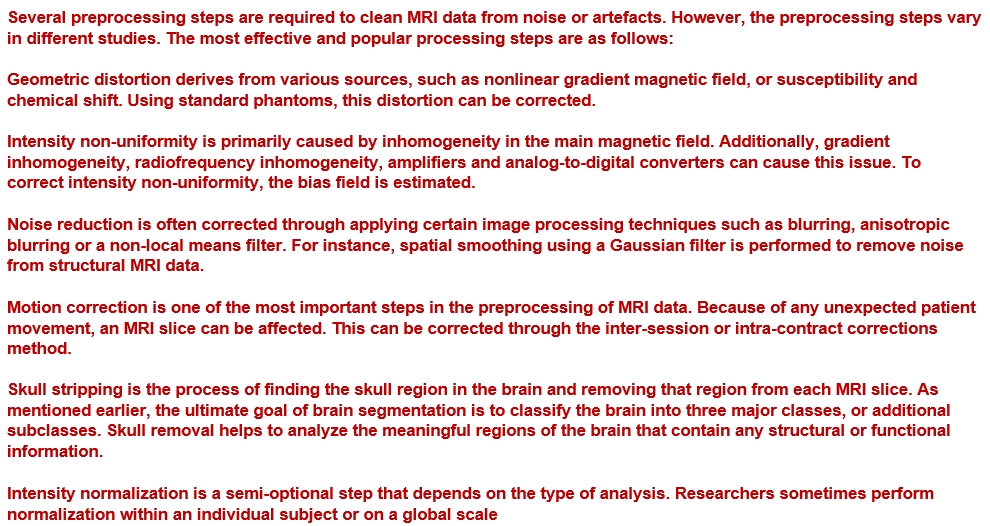

(256, 256, 4)
[[[  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]]

 [[  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]]

 [[  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]]

 ...

 [[  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]]

 [[  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]]

 [[  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]]]
[[255, 255, 255, 255], [170, 170, 170, 255], [85, 85, 85, 255], [0, 0, 0, 255]]
tf.Tensor(
[[[0 0 0 1]
  [0 0 0 1]
  [0 0 0 1]
  ...
  [0 0 0 1]
  [0 0 0 1]
  [0 0 0 1]]

 [[0 0 0 1]
  [0 0 0 1]
  [0 0 0 1]
  ...

(-0.5, 255.5, 255.5, -0.5)

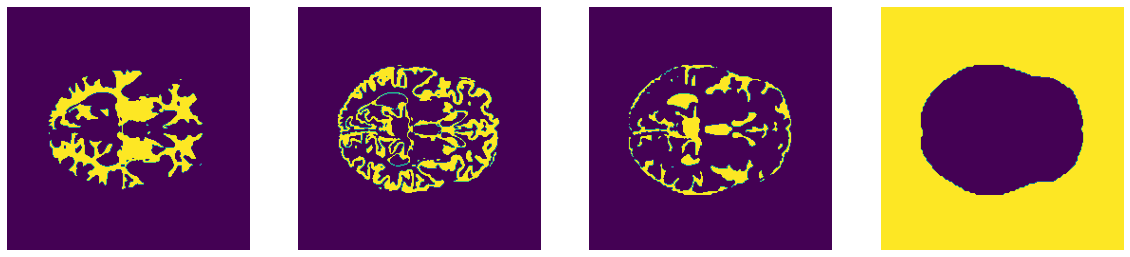

In [ ]:
test = cv2.cvtColor(cv2.imread((slices_seg_train[0])), cv2.COLOR_RGB2RGBA)
print(test.shape)
print(test)

my_list= []
for i in range(256):
    for j in range(256):
        my_list.append(test[i,j,:].tolist())

def uniq(lst):
    last = object()
    for item in lst:
        if item == last:
            continue
        yield item
        last = item

def sort_and_deduplicate(l):
    return list(uniq(sorted(l, reverse=True)))

palette = sort_and_deduplicate(my_list)
print(palette)

#[[255, 255, 255, 255], [170, 170, 170, 255], [85, 85, 85, 255], [0, 0, 0, 255]]

one_hot_map = []

for clr in palette:
    class_map = tf.equal(test, clr)
    class_map = tf.reduce_all(class_map,axis=-1)
    one_hot_map.append(class_map)
    
one_hot_map = tf.stack(one_hot_map, axis=-1)
one_hot_map = tf.cast(one_hot_map, tf.uint8)

print(one_hot_map)

plt.figure(figsize=(20, 10))

plt.subplot(1, 4, 1)
plt.imshow(one_hot_map[:,:,0])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(one_hot_map[:,:,1])
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(one_hot_map[:,:,2])
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(one_hot_map[:,:,3])
plt.axis('off')

Generate training dataset

A | B
- | - 
![alt](https://media0.giphy.com/media/2bYewTk7K2No1NvcuK/200.gif) | ![alt](https://thumbs.gfycat.com/DisloyalGlossyCrayfish-max-1mb.gif)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((slices_train, slices_seg_train))
val_ds = tf.data.Dataset.from_tensor_slices((slices_val, slices_seg_val))

test_ds = tf.data.Dataset.from_tensor_slices((slices_test, slices_seg_test))

In [ ]:
train_ds = train_ds.shuffle(len(slices_train))
val_ds = val_ds.shuffle(len(slices_val))

test_ds = val_ds.shuffle(len(slices_test))

Build and Train the Classifier


In [ ]:
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 4

In [ ]:
def decode_img(image):
    image = tf.image.decode_png(image, channels=IMG_CHANNELS)
    # resize the image 256 224*256 
    image =  tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    # Standardise values to be in the [0, 1] range.
    image = tf.cast(image, tf.float32) / 255.0
    
    return image
    
def decode_label(label):
    label = tf.image.decode_png(label, channels=4)
    # Resize the image to the desired size.
    label =  tf.image.resize(label, [IMG_WIDTH, IMG_HEIGHT])
    print(label.shape)
    
    one_hot_map = []

    for clr in palette:
        class_map = tf.equal(label, clr)
        class_map = tf.reduce_all(class_map,axis=-1)
        one_hot_map.append(class_map)
    
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.uint8)
    
    return one_hot_map
    
def process_data(image, label):
    image = tf.io.read_file(image)
    image = decode_img(image)
    
    label = tf.io.read_file(label)
    label = decode_label(label)
    
    return image, label   

In [ ]:
# Use Dataset.map to apply this transformation.
processed_train_ds = train_ds.map(process_data)
processed_val_ds = val_ds.map(process_data)

processed_test_ds = test_ds.map(process_data)

(256, 256, 4)
(256, 256, 4)
(256, 256, 4)


## Image modalities

**Segmentation is the primary task for U-net models. The goal of segmentation tasks is to outline and separate different objects in an image, i.e. to classify different objects rather than classifying the whole image. This is of particular importance in the medical imaging community as the diagnosis of medical conditions requires careful analysis of local regions in an image.** 

**For instance, the diagnosis of brain tumors would require separating the tumors from the rest of the brain structures. We have found extensive use of the U-net architecture for an assortment of medical imaging analysis. In the next section, we discuss the major image modalities on which U-net has been applied.**

Image shape: b'./../keras_png_slices_data/keras_png_slices_train\\case_301_slice_25.nii.png'
Label: b'./../keras_png_slices_data/keras_png_slices_seg_train\\seg_301_slice_25.nii.png'

Image shape: (256, 256, 4)
Label: (256, 256, 4)
the above file is not the file for the pic bellow
tf.Tensor(
[[[0 0 0 1]
  [0 0 0 1]
  [0 0 0 1]
  ...
  [0 0 0 1]
  [0 0 0 1]
  [0 0 0 1]]

 [[0 0 0 1]
  [0 0 0 1]
  [0 0 0 1]
  ...
  [0 0 0 1]
  [0 0 0 1]
  [0 0 0 1]]

 [[0 0 0 1]
  [0 0 0 1]
  [0 0 0 1]
  ...
  [0 0 0 1]
  [0 0 0 1]
  [0 0 0 1]]

 ...

 [[0 0 0 1]
  [0 0 0 1]
  [0 0 0 1]
  ...
  [0 0 0 1]
  [0 0 0 1]
  [0 0 0 1]]

 [[0 0 0 1]
  [0 0 0 1]
  [0 0 0 1]
  ...
  [0 0 0 1]
  [0 0 0 1]
  [0 0 0 1]]

 [[0 0 0 1]
  [0 0 0 1]
  [0 0 0 1]
  ...
  [0 0 0 1]
  [0 0 0 1]
  [0 0 0 1]]], shape=(256, 256, 4), dtype=uint8)


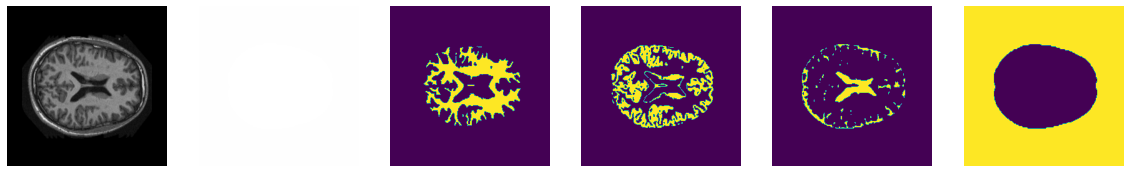

In [ ]:
for image, label in train_ds.take(1):
    print('Image shape:', image.numpy())
    print('Label:', label.numpy())
print()
for image, label in processed_train_ds.take(1):
    print('Image shape:', image.numpy().shape)
    print('Label:', label.numpy()[:,:,:].shape)
print('the above file is not the file for the pic bellow')
plt.figure(figsize=(20, 10))


print(label)
plt.subplot(1, 6, 1)
plt.imshow(image.numpy())
plt.axis('off')

plt.subplot(1, 6, 2)
plt.imshow(label.numpy()[:,:,:])
plt.axis('off')

plt.subplot(1, 6, 3)
plt.imshow(label.numpy()[:,:,0])
plt.axis('off')

plt.subplot(1, 6, 4)
plt.imshow(label.numpy()[:,:,1])
plt.axis('off')

plt.subplot(1, 6, 5)
plt.imshow(label.numpy()[:,:,2])
plt.axis('off')

plt.subplot(1, 6, 6)
plt.imshow(label.numpy()[:,:,3])
plt.axis('off')
    
plt.show()

In [ ]:
# for image, label in processed_train_ds.take(1):
#     a = image.numpy()
#     b = label.numpy()
# for i in range(len(b)):
#     for j in range(len(b[i])):
#         print(i, "-", j, ": ", b[i][j])

## Traditional U-Net model 
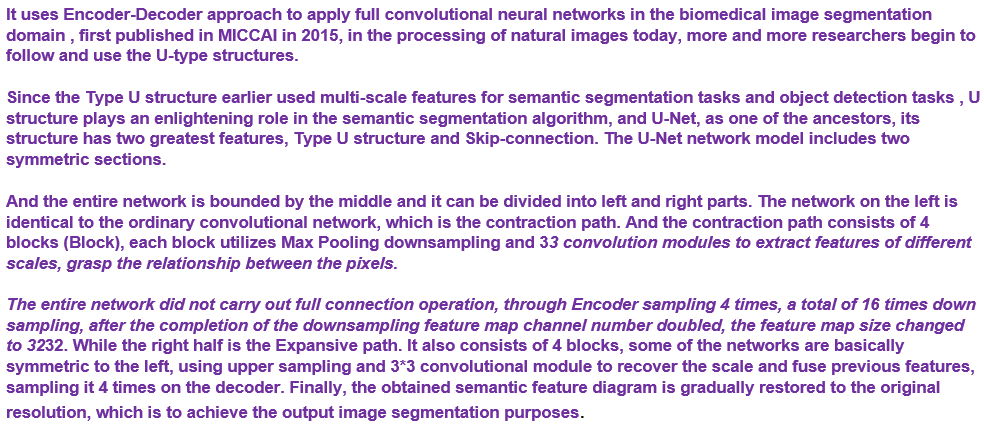

In [ ]:
inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
INIT_FILTER = 32
hn = 'he_normal'
dropout = 0.2

conv1 = Conv2D(INIT_FILTER * 1, (3,3), activation = 'relu', padding = 'same')(inputs)
conv1 = Conv2D(INIT_FILTER * 1, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(INIT_FILTER * 2, (3,3), activation = 'relu', padding = 'same')(pool1)
conv2 = Conv2D(INIT_FILTER * 2, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(INIT_FILTER * 3, (3,3), activation = 'relu', padding = 'same')(pool2)
conv3 = Conv2D(INIT_FILTER * 3, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(INIT_FILTER * 4, (3,3), activation = 'relu', padding = 'same')(pool3)
conv4 = Conv2D(INIT_FILTER * 4, (3,3), activation = 'relu', padding = 'same')(conv4)
drop4 = Dropout(dropout)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(INIT_FILTER * 5, (3,3), activation = 'relu', padding = 'same')(pool4)
conv5 = Conv2D(INIT_FILTER * 5, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(dropout)(conv5)

up6 = Conv2D(INIT_FILTER * 4, (2,2), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop5))
concat6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(INIT_FILTER * 4, (3,3), activation = 'relu', padding = 'same')(concat6)
conv6 = Conv2D(INIT_FILTER * 4, (3,3), activation = 'relu', padding = 'same')(conv6)

up7 = Conv2D(INIT_FILTER * 3, (2,2), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv6))
concat7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(INIT_FILTER * 3, (3,3), activation = 'relu', padding = 'same')(concat7)
conv7 = Conv2D(INIT_FILTER * 3, (3,3), activation = 'relu', padding = 'same')(conv7)

up8 = Conv2D(INIT_FILTER * 2, (2,2), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))
concat8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(INIT_FILTER * 2, (3,3), activation = 'relu', padding = 'same')(concat8)
conv8 = Conv2D(INIT_FILTER * 2, (3,3), activation = 'relu', padding = 'same')(conv8)

up9 = Conv2D(INIT_FILTER * 1, (2,2), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
concat9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(INIT_FILTER * 1, (3,3), activation = 'relu', padding = 'same')(concat9)
conv9 = Conv2D(INIT_FILTER * 1, (3,3), activation = 'relu', padding = 'same')(conv9)

outputs = Conv2D(4, (1,1), activation = 'softmax')(conv9)

model = Model(inputs = inputs, outputs = outputs)

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d_186 (Conv2D)             (None, 256, 256, 32) 1184        input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_187 (Conv2D)             (None, 256, 256, 32) 9248        conv2d_186[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_52 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_187[0][0]                 
____________________________________________________________________________________________

## Improved U-Net Network Model
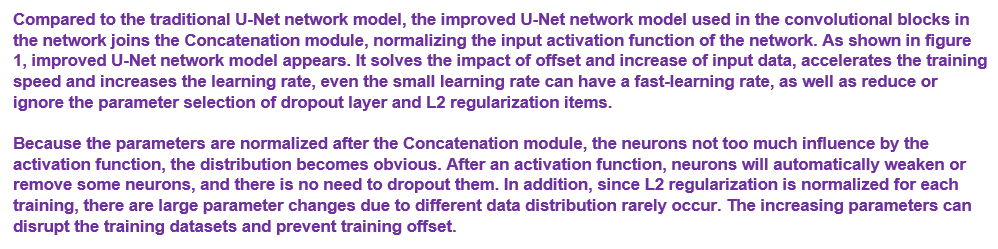


In [ ]:
history = model.fit(processed_train_ds.batch(BATCH_SIZE), 
                    validation_data=processed_val_ds.batch(BATCH_SIZE), 
                    epochs=5)


Train for 302 steps, validate for 35 steps
Epoch 1/5
302/302 [==============================] - 364s 1s/step - loss: 0.2366 - accuracy: 0.9106 - val_loss: 0.0772 - val_accuracy: 0.9679
Epoch 2/5
302/302 [==============================] - 306s 1s/step - loss: 0.0600 - accuracy: 0.9752 - val_loss: 0.0431 - val_accuracy: 0.9820
Epoch 3/5
302/302 [==============================] - 238s 789ms/step - loss: 0.0419 - accuracy: 0.9826 - val_loss: 0.0382 - val_accuracy: 0.9840
Epoch 4/5
302/302 [==============================] - 151s 500ms/step - loss: 0.0362 - accuracy: 0.9850 - val_loss: 0.0314 - val_accuracy: 0.9867
Epoch 5/5
302/302 [==============================] - 425s 1s/step - loss: 0.0334 - accuracy: 0.9860 - val_loss: 0.0319 - val_accuracy: 0.9865


In [ ]:
image_train_batch, label_train_batch = next(iter(processed_train_ds.batch(9)))
image_val_batch, label_val_batch = next(iter(processed_val_ds.batch(9)))
image_test_batch, label_test_batch = next(iter(processed_test_ds.batch(9)))

preds_train = model.predict(image_train_batch)
preds_val = model.predict(image_val_batch)
preds_test = model.predict(image_test_batch)

In [ ]:
test_loss, test_acc = model.evaluate(processed_test_ds.batch(BATCH_SIZE), verbose=2)

35/35 - 44s - loss: 0.0319 - accuracy: 0.9865


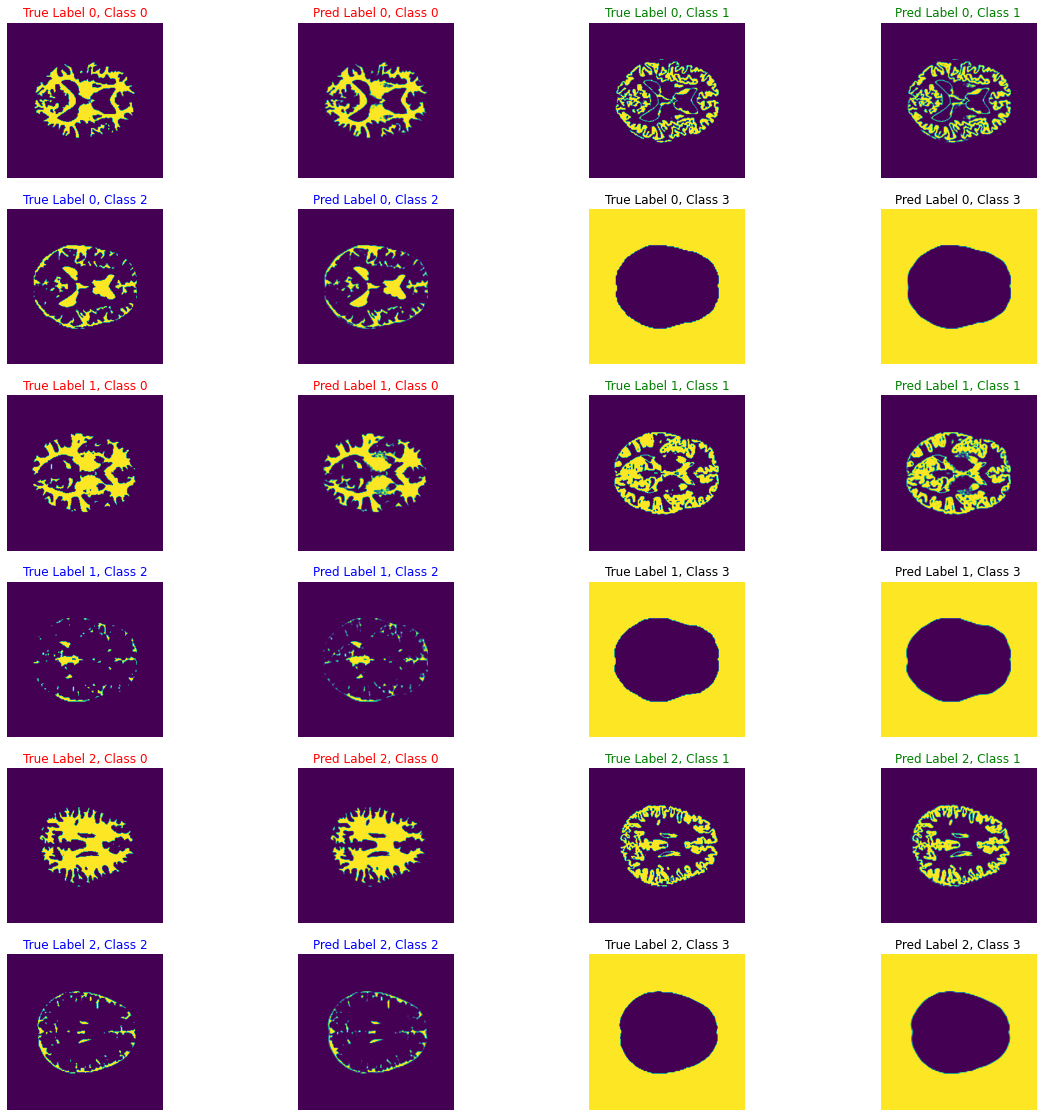

In [ ]:
pred_num = 3

def show_predictions():

    plt.figure(figsize=(20, 20))
    idx = 1
    colors = ['red', 'green', 'blue', 'black']
    for i in range(pred_num):
        # looping for each class
        for j in range(4):
            # Subplot for Truth Label
            plt.subplot(pred_num*2, 4, idx)
            plt.imshow(label_test_batch[i][:,:,j])
            title = plt.title('True Label {}, Class {}'.format(i, j))
            plt.setp(title, color=colors[j])
            plt.axis('off')
            idx+=1

            # Subplot for Pred Labels
            plt.subplot(pred_num*2, 4, idx)
            plt.imshow(preds_test[i][:,:,j])
            title = plt.title('Pred Label {}, Class {}'.format(i, j))
            plt.setp(title, color=colors[j])
            plt.axis('off')
            idx+=1
    plt.show()
    
show_predictions()

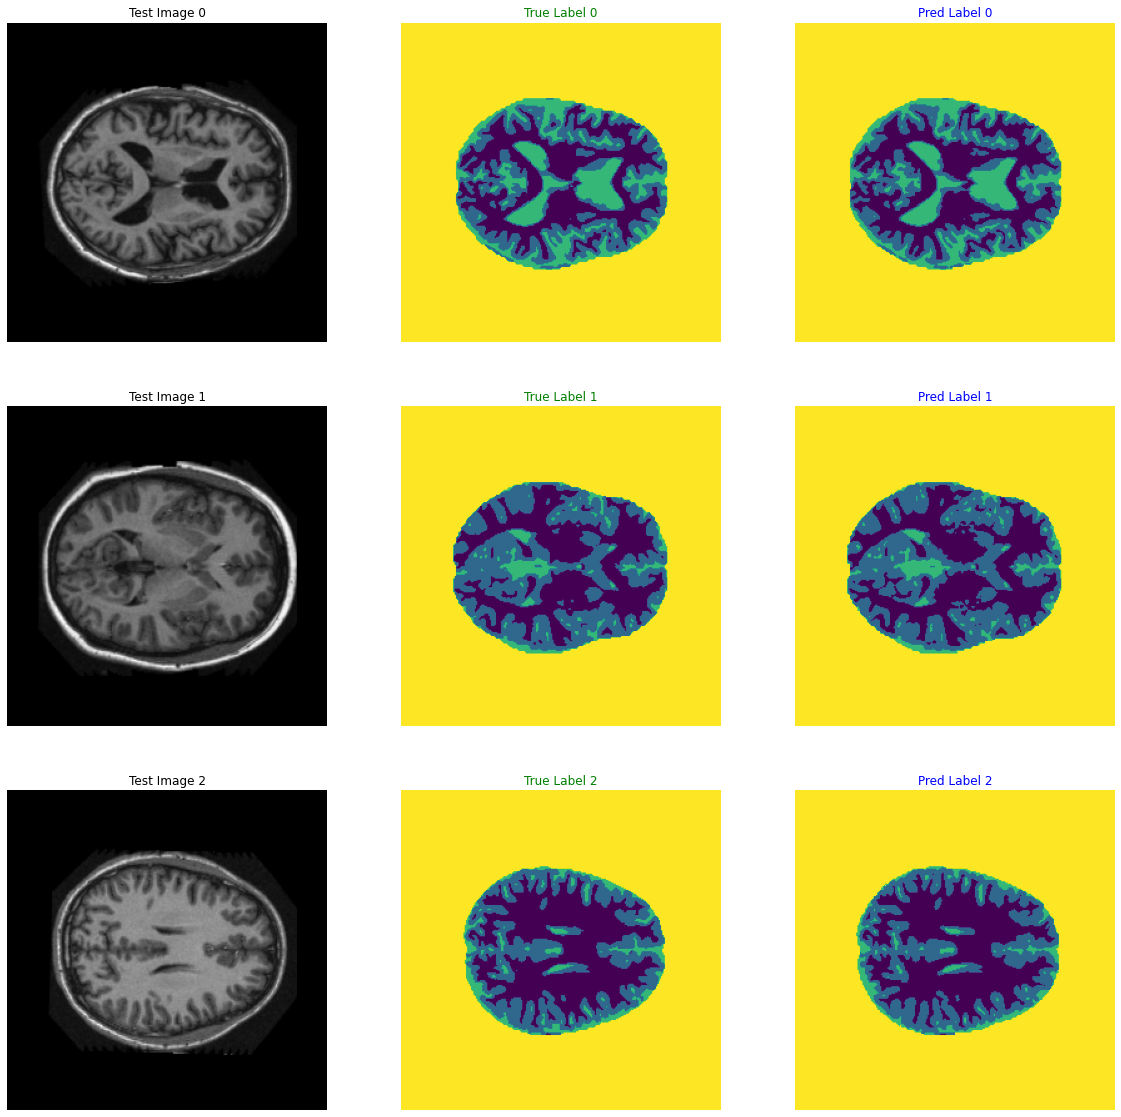

In [ ]:
def show_predictions2():
    plt.figure(figsize=(20, 20))
    idx = 1
    colors = ['black', 'green', 'blue']
    
    for i in range(pred_num):
        # Subplot for the test image
        plt.subplot(pred_num, 3, (i*3)+1)
        plt.imshow(image_test_batch[i])
        title = plt.title('Test Image {}'.format(i))
        plt.setp(title, color=colors[0])
        plt.axis('off')
        
        # Subplot for Truth Label
        plt.subplot(pred_num, 3, (i*3)+2)
        plt.imshow(tf.argmax(label_test_batch[i], axis=2))
        title = plt.title('True Label {}'.format(i))
        plt.setp(title, color=colors[1])
        plt.axis('off')

        # Subplot for Pred Labels
        plt.subplot(pred_num, 3, (i*3)+3)
        plt.imshow(tf.argmax(preds_test[i], axis=2))
        title = plt.title('Pred Label {}'.format(i))
        plt.setp(title, color=colors[2])
        plt.axis('off')

show_predictions2()   

**Mean squared error (MSE) is a loss function that is used to solve regression problems. MSE is calculated as the average of the squared differences between the actual and predicted values.**

**The Structural Similarity Index (SSIM) is a perceptual metric that quantifies the image quality degradation that is caused by processing such as data compression or by losses in data transmission. This metric is basically a full reference that requires 2 images from the same shot, this means 2 graphically identical images to the human eye.**

**The second image generally is compressed or has a different quality, which is the goal of this index. SSIM is usually used in the video industry, but has as well a strong application in photography. SIM actually measures the perceptual difference between two similar images. It cannot judge which of the two is better: that must be inferred from knowing which is the original one and which has been exposed to additional processing such as compression or filters.**

In [ ]:
#################################################################
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    imageA = np.array(imageA)
    imageB = np.array(imageB)
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err
#################################################################
from skimage.metrics import structural_similarity as ssim

def sk_ssim(imageA, imageB):
    imageA = np.array(imageA)
    imageB = np.array(imageB)
    s = ssim(imageA, imageB, multichannel=True)
    return s
#################################################################
def tf_ssim(im1, im2):
    im1 = tf.cast(tf.convert_to_tensor(im1), tf.float32)
    im2 = tf.cast(tf.convert_to_tensor(im2), tf.float32)
#     print(im1)
#     print(im2)
    
    return tf.image.ssim(im1, im2, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
#################################################################
for i in range(pred_num):
    print("MSE AND SSIM FOR LABEL {}:".format(i))
    print("\t MSE: {}".format(mse(label_test_batch[i], preds_test[i])))
    print("\t SSIM (skimage): {}".format(sk_ssim(label_test_batch[i], preds_test[i])))
    print("\t SSIM (tensorflow): {}".format(tf_ssim(label_test_batch[i], preds_test[i])))
    print()

MSE AND SSIM FOR LABEL 0:
	 MSE: 0.017750639626609378
	 SSIM (skimage): 0.9998726270544178
	 SSIM (tensorflow): 0.9665305018424988

MSE AND SSIM FOR LABEL 1:
	 MSE: 0.01739061270670763
	 SSIM (skimage): 0.9998467614175952
	 SSIM (tensorflow): 0.9562726020812988

MSE AND SSIM FOR LABEL 2:
	 MSE: 0.01734985682059616
	 SSIM (skimage): 0.9998722574305513
	 SSIM (tensorflow): 0.963498055934906



## We obtained a decently high level of success

###  MSE: 0.017750639626609378 	 SSIM (skimage): 0.9998726270544178 	 SSIM (tensorflow): 0.9665305018424988


## Conclusion and Future Work

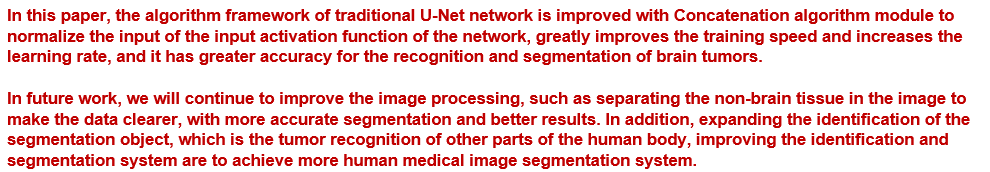

